# Semantic Analysis with Word Embeddings

In this notebook, we will be using word embeddings to perform semantic analysis on a dataset of sentences. Our tasks include tokenization of the text, generating a word2vec model, and measuring cosine similarity between different word vectors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import nltk
import string
import bz2
import time

import gensim.downloader as api
from sklearn.metrics import zero_one_loss
from collections import defaultdict
from gensim.models.doc2vec import Doc2Vec, Word2Vec
from nltk.tokenize import RegexpTokenizer, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from scipy import linalg
from tqdm import tqdm
from numpy import count_nonzero

from scipy import linalg
from tqdm import tqdm
from numpy import count_nonzero

from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_files

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib notebook

### Data Loading

You can access the data here: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?select=IMDB+Dataset.csv

In [2]:
df = pd.read_csv('data\\imbd_movie_reviews.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Clean Text

In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub('<.*?>', ' ', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text

In [4]:
df['review'] = df['review'].apply(clean_text)
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was wonderful way to spend time...,positive
3,basically there a family where little boy jake...,negative
4,petter mattei love in the time of money is vis...,positive
...,...,...
49995,i thought this movie did down right good job i...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,i am catholic taught in parochial elementary s...,negative
49998,i going to have to disagree with the previous ...,negative


### Text Tokenization

In [5]:
def tokenize(df: pd.DataFrame, text_col: str):
    df['tokenized_text'] = [word_tokenize(text) for text in df[text_col]]
    return df

In [6]:
tokenize(df, 'review')

,review,sentiment,tokenized_text
0,one of the other reviewers has mentioned that ...,positive,"[one, of, the, other, reviewers, has, mentione..."
1,a wonderful little production the filming tech...,positive,"[a, wonderful, little, production, the, filmin..."
2,i thought this was wonderful way to spend time...,positive,"[i, thought, this, was, wonderful, way, to, sp..."
3,basically there a family where little boy jake...,negative,"[basically, there, a, family, where, little, b..."
4,petter mattei love in the time of money is vis...,positive,"[petter, mattei, love, in, the, time, of, mone..."
...,...,...,...
49995,i thought this movie did down right good job i...,positive,"[i, thought, this, movie, did, down, right, go..."
49996,bad plot bad dialogue bad acting idiotic direc...,negative,"[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,i am catholic taught in parochial elementary s...,negative,"[i, am, catholic, taught, in, parochial, eleme..."
49998,i going to have to disagree with the previous ...,negative,"[i, going, to, have, to, disagree, with, the, ..."


### Building the Word2Vec Model

Word2Vec for our tokenized sentences uses a neural network model to learn word associations from a large corpus of text.

In [7]:
# Tokenizing sentences
max_iter = None
tokenized_sentences = list()

for counter, file in enumerate(df['review'].to_list()):
    sentence_list = file.split(".")
    for sentence in sentence_list:
        tokenized_sentences.append(word_tokenize(sentence))
    if counter == max_iter:
        break

# Building Word2Vec model
we_model = Word2Vec(tokenized_sentences, min_count=1)

# Printing some information about our Word2Vec model
print(f'Number of tokenized sentences: {len(tokenized_sentences)}')
words = list(we_model.wv.key_to_index)

print(f'\n5 most similar words of: movie')
print(np.array(we_model.wv.most_similar('movie', topn=5)))

print(f'\n5 most similar words of: wonderful')
print(np.array(we_model.wv.most_similar('wonderful', topn=5)))

Number of tokenized sentences: 50000

5 most similar words of: movie
[['film' '0.9270629286766052']
 ['flick' '0.7445328235626221']
 ['it' '0.6786115169525146']
 ['show' '0.6534948348999023']
 ['documentary' '0.617907702922821']]

5 most similar words of: wonderful
[['fantastic' '0.869448721408844']
 ['great' '0.8130712509155273']
 ['fabulous' '0.808513343334198']
 ['brilliant' '0.7978602647781372']
 ['terrific' '0.7967132329940796']]


### Calculating Cosine Similarity

Now that we have our Word2Vec model, we can use it to find semantic similarity between words. We're going to be using cosine similarity as a measure of similarity between two vectors.

In [8]:
def cos_sim(v1,v2):
    # (v1 * v2^T) / (|v1|*|v2|)
    return float(np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2)))

### Semantic Comparison

Now we compare the cosine similarities of selected words with each other.

In [9]:
source_words = ['movie', 'wonderful', 'job']
other_words = ['film', 'bad', 'great', 'production', 'expected']

print(f'We compare the cosine similarities of the following 2 lists with each other')
print(f'source_words =  {source_words}')
print(f'other_words =  {other_words}')


for first_i in range(3):
    #print('Cosine similarity of')
    print('\n')
    for second_i in range(5):
        cos_sim_val = cos_sim(we_model.wv[source_words[first_i]], we_model.wv[other_words[second_i]])
        print(f'cos_sim({source_words[first_i]}, {other_words[second_i]}) = {cos_sim_val}')
        
        # make a sanity check with the help of 
        cos_sim_sk_val = float(cosine_similarity([we_model.wv[source_words[first_i]]], [we_model.wv[other_words[second_i]]]))
        if round(cos_sim_val, 4) != round(cos_sim_sk_val, 4):
            raise ValueError(f'{round(cos_sim_val, 4)} != {round(cos_sim_sk_val, 4)}')

We compare the cosine similarities of the following 2 lists with each other
source_words =  ['movie', 'wonderful', 'job']
other_words =  ['film', 'bad', 'great', 'production', 'expected']


cos_sim(movie, film) = 0.9270630478858948
cos_sim(movie, bad) = 0.33013007044792175
cos_sim(movie, great) = 0.21709184348583221
cos_sim(movie, production) = 0.4643268287181854
cos_sim(movie, expected) = 0.2035398632287979


cos_sim(wonderful, film) = 0.133778914809227
cos_sim(wonderful, bad) = 0.25050148367881775
cos_sim(wonderful, great) = 0.8130712509155273
cos_sim(wonderful, production) = 0.06062145158648491
cos_sim(wonderful, expected) = 0.058106232434511185


cos_sim(job, film) = 0.24156033992767334
cos_sim(job, bad) = 0.0614447258412838
cos_sim(job, great) = 0.09139727801084518
cos_sim(job, production) = 0.1941676288843155
cos_sim(job, expected) = 0.005619989708065987


### k-Nearest Neighbors Calculation

Next, we're going to define a function to calculate the k-nearest neighbors for a given word vector.

In [10]:
def knn(source_vector, target_vectors, words, k=10):
    """
    computes the knn of a source and some traget vector efficiently
    
    Returns:
        indices of k nearest neighbors of a source_vector wrt target_vectors, list with k nearest words
    """
    
    # source_vector * (target_vectors^T)
    s_dot_t = source_vector.copy().dot(np.transpose(target_vectors.copy()))
    
    # then compute L2 norm of every row in the transposed target_vectors, to get a new vector called norms
    # we can leave out np.linalg.norm(source_vector) for norms, because it's constant for all the entries
    norms = np.sum(np.abs(target_vectors.copy())**2,axis=-1)**(1./2)
    
    # lst step is to divide, in order to obtain the cosine distances
    cos_dists = s_dot_t / norms
    
    # get the best indices by argsort
    indices = np.argsort(cos_dists)[-k:]
    
    return indices, [words[i] for i in indices]

### k-Nearest Neighbors for Multiple Vectors

This function is an optimized version of the previous k-nearest neighbors function that can handle multiple vectors simultaneously.

#### Approach:

For now we stick with the requirements and write the function knn. It takes one source vector and computes the k most similar vectors w.r.t. the target vectors.

More formally:
We are given a vector $s_{d}$ and a matrix $T_{dxm}$ and want to compute $\frac{s \cdot T}{|s|\cdot|T|}$ to obtain a vector of length $m$. In our example we chose $d=100$. This doesn't change the length of the resulting vector. Finally we just need to take the argmax of the resulting vector to obtain the indices with the highest values of the resulting vector $r_{m}$. Those are the k nearest neighbors to the source vector w.r.t. the matrix with the target vectors.

For higher dimensions:
With the funciton knn_multiple (below) we can take multiple source vectors at once, which doesn't change much of the mathematics. The source vectors are given by a matrix $S_{nxd}$ then, where we choose d=100. The resulting vectors are stored in a matrix $R_{nxm}$. This is way faster than calling knn in a loop and safes us much time.

In [11]:
def knn_multiple(source_vectors, target_vectors, words, k=10):
    """
    Computes the knn of one or multiple source vectors w.r.t. some target vectors efficiently.
    
    Args:
        source_vectors: The vectors we are intrested in.
                        Has shape (n,100) where n is the number of vectors.
        target_vectors: All the vectors we want to compare the source vectors with.
        words: Array of words in correct order. 
        k: Number of Neighbors.
        
    Returns:
        indices of k nearest neighbors of a source_vector wrt target_vectors, list with k nearest words
    """
    # make one or multiple arrays 2-dimensional. This makes the matrix computations easier.
    new_dim = (1,len(source_vectors)) if source_vectors.ndim == 1 else np.shape(source_vectors)
    
    # reshape the source vectors according to new_dim
    source_vectors_reshaped = source_vectors.copy().reshape(new_dim)
    
    # source_vectors_reshaped * (target_vectors^T)
    s_dot_t = source_vectors_reshaped.copy().dot(np.transpose(target_vectors.copy()))
    
    # then compute L2 norm of every row in the transposed target_vectors, to get a new vector called norms
    # we can leave out np.linalg.norm(source_vector) for norms, because it's constant per entry
    norms = np.sum(np.abs(target_vectors.copy())**2,axis=-1)**(1./2)
    
    # lastly, we want to obtain the cosine distances
    cos_dists = s_dot_t / norms
    
    # get the best indices by argsort per source vector
    indices = np.argsort(cos_dists)[:,-k:]
    
    return indices, np.array([list(np.array(words)[indices.tolist()[i]]) for i in range(new_dim[0])])

### Performance Comparison: Loop vs Matrix Approach

Let's compare the performance of computing the k-nearest neighbors for multiple vectors in a loop versus using the matrix approach.

In [12]:
max_added = 50
total_added = 0
test_knn_array = np.zeros((max_added, 100))

for sentence in tokenized_sentences:
    if total_added == max_added:
            break
    for word in sentence:
        if total_added == max_added:
            break
        try:
            test_knn_array[total_added] = we_model.wv[word]
            total_added += 1
        except:
            continue

print(f'len(test_knn_array): {len(test_knn_array)}')

start_time = time.time()
for word_vec in test_knn_array:
    indices, words  = knn(word_vec, we_model.wv[we_model.wv.index_to_key], we_model.wv.index_to_key, k=10)
end_time = time.time()
knn_loop_time = end_time-start_time
print(f'knn() in a loop took {round(knn_loop_time,4)} seconds for {max_added} samples.')

start_time = time.time()
knn_multiple(test_knn_array, we_model.wv[we_model.wv.index_to_key], we_model.wv.index_to_key, k=10)
end_time = time.time()
knn_matrix_time = end_time-start_time
print(f'knn_multiple() took {round(knn_matrix_time,4)} seconds for {max_added} samples.')

print(f'So the matrix approach for multiple source vectors is {round(knn_loop_time/knn_matrix_time, 4)} times faster than calling knn for every vector in a loop.')
print('(Even better results for large sample sizes)')

len(test_knn_array): 50
knn() in a loop took 14.95 seconds for 50 samples.
knn_multiple() took 3.0404 seconds for 50 samples.
So the matrix approach for multiple source vectors is 4.9171 times faster than calling knn for every vector in a loop.
(Even better results for large sample sizes)


<IPython.core.display.Javascript object>


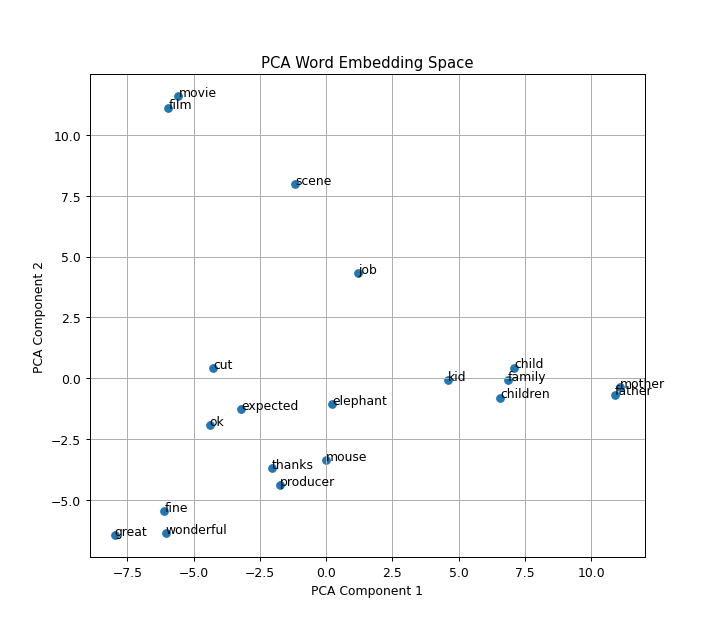

Enter word to add to the PCA plot ('quit' for stopping): family
Added word 'family' to PCA plot.
Enter word to add to the PCA plot ('quit' for stopping): great
Added word 'great' to PCA plot.
Enter word to add to the PCA plot ('quit' for stopping): fine
Added word 'fine' to PCA plot.
Enter word to add to the PCA plot ('quit' for stopping): ok
Added word 'ok' to PCA plot.
Enter word to add to the PCA plot ('quit' for stopping): producer
Added word 'producer' to PCA plot.
Enter word to add to the PCA plot ('quit' for stopping): child
Added word 'child' to PCA plot.
Enter word to add to the PCA plot ('quit' for stopping): kid
Added word 'kid' to PCA plot.
Enter word to add to the PCA plot ('quit' for stopping): children
Added word 'children' to PCA plot.
Enter word to add to the PCA plot ('quit' for stopping): mother
Added word 'mother' to PCA plot.
Enter word to add to the PCA plot ('quit' for stopping): father
Added word 'father' to PCA plot.
Enter word to add to the PCA plot ('quit' fo

In [13]:
# select initial words for plotting
selected_words = ['movie', 'wonderful', 'job', 'film', 'expected']

# create PCA model
pca = PCA(n_components=2)

# create figure
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

def plot_with_pca(word_list, model):
    
    ''' This function plots words using a model (PCA)'''
    
    # clear current plot
    ax.clear()
    
    word_vectors = np.array([model.wv[word] for word in word_list])
    
    # apply PCA
    pca_components = pca.fit_transform(word_vectors)
    
    ax.scatter(pca_components[:, 0], pca_components[:, 1])
    
    for i, word in enumerate(word_list):
        ax.annotate(word, xy=(pca_components[i, 0], pca_components[i, 1]))
        
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_title('PCA Word Embedding Space')
    ax.grid(True)
    
    # give updated plot
    fig.canvas.draw()

plot_with_pca(selected_words, we_model)

while True:
    # User input
    user_word = input("Enter word to add to the PCA plot ('quit' for stopping): ")
    
    if user_word.lower() == 'quit':
        break

    # Check if the word is in the model's vocabulary
    if user_word in we_model.wv.key_to_index:
        print(f"Added word '{user_word}' to PCA plot.")
        selected_words.append(user_word)
        plot_with_pca(selected_words, we_model)
    else:
        print(f"The word '{user_word}' is not in the model's vocabulary.")